<a href="https://colab.research.google.com/github/ssundar6087/Keras-Slack-Logging/blob/master/Keras_Slack_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras Callbacks with Slack
===========================

Here's a very simple notebook showing how you can use [Keras](https://keras.io) callbacks to send you updates of your training run to Slack!

**Disclaimers:**
1. This is _one_ of the ways to do this, and there are perhaps better ways to do this than what I've shown here.

2. The objective of this notebook is **not** to show some model train to SOTA, so the hyperparameters are randomly chosen just to show the model training.

3. For specific usage questions, check out the [WebClient API](https://slack.dev/node-slack-sdk/web-api)

**What's not covered here:**
I will be writing a blog post to accompany this notebook to walk through some of the things that are not covered here:

1. Setting up your slack workspace
2. Creating a bot and a slack api token
3. Possible Kaggle Integration

## Setup Slackclient


In [12]:
!pip3 install slackclient

## Usual Imports


In [13]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Slack Part
This is the part you would need to modify and integrate into your script

### Slack specific imports
Two points to note here:
1. You **NEED** to have a [Slack API token](https://slack.com/help/articles/215770388-Create-and-regenerate-API-tokens) to get any of this to work.
2. Don't paste the API token in all your notebooks/scripts. It's **not** safe! Did I mention that it's **not** safe?
  - I use google drive as a way to import my api token into scripts where I'd like Slack notifications.

In [0]:
from slack import WebClient
from slack.errors import SlackApiError

In [15]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change the path below to point to your API token

In [0]:
token_file_path = "PATH/TO/YOUR/SLACK_API_TOKEN"
f = open(token_file_path, "r")
api_token= f.read()

### Here's the Main Puzzle Piece
A Keras callback has some really nifty features where you can get information on the loss and accuracy values at regular intervals. We will be piggybacking on these callbacks to send messages to a slack channel of our choosing.

In [0]:
class SlackCallback(keras.callbacks.Callback):
    def __init__(self, 
                 token, 
                 channel='general', 
                 monitor='val_loss', 
                 mode='min',
                 message='Epoch {epoch:03d} loss:{loss:.4f} val_loss:{val_loss:.4f}',
                 model_description='Hello World',
                 plot=['loss','val_loss']):
        super(SlackCallback, self).__init__()
                 
        # The Slack API token
        self.token=token

        # The Slack Channel to Post to
        self.channel=channel

        # This allows you to create a thread and then post each new update 
        # within a thread: Prevents an explosion of new messages in the channel
        self.thread_id=None

        # What to print in the channel
        self.message=message

        # Bells and Whistles   
        self.monitor=monitor
        self.losses=[]
        self.error=False
        self.model_description=model_description
        if mode=='min':
            self.operation=np.less
            self.best=np.Inf
        if mode=='max':
            self.operation=np.greater
            self.best=-np.Inf
        
        self.best_logs={}
        self.best_epoch=1
        self.plot=plot or [] 


    # Initialize things here
    # If you can't send a basic message to slack, something's wrong
    # with the setup
    def on_train_begin(self, logs={}):
        response=self.send_message(self.model_description)
        if response['ok']:
            self.error=False
            # Attach every subsequent message (training logs) to this thread
            self.thread_id=response['ts']
        else:
            self.error=True
            warnings.warn('Slack error:'+str(response))
        
    # After every epoch, we send updates to the channel with the latest values
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs)
        if self.operation(logs[self.monitor],self.best):
            self.send_message(self.message.format(epoch=epoch+1,**logs))
            self.best=logs[self.monitor]
            self.best_logs=logs
            self.best_epoch=epoch+1

    # At the end of training, send the statistics of the best model 
    # and send a plot of the training loss curves
    def on_train_end(self, logs=None):
        self.send_message('Best Model has:\n'+self.message.format(epoch=self.best_epoch,**self.best_logs))
        plt.figure(figsize=(10,10))
        for p in self.plot:
            plt.plot([log[p] for log in self.losses],label=p)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.legend()
            plt.title("Loss Curve")

        # You can probably make this more fancy
        out = 'LearningCurve.png'
        plt.savefig(fname=out,format='png')
        response=self.send_image(filename=out)
        plt.show()
    
    # Helper method 1: Sends a message to the slack channel
    def send_message(self,text):
        if not self.error:
          sc = WebClient(self.token)
          return sc.chat_postMessage(channel=self.channel,text=text,thread_ts=self.thread_id)
    
    # Helper method 2: Sends a file to the slack channel
    def send_image(self,filename):
        if not self.error:
            sc = WebClient(self.token)
            file_path=filename
            with open(file_path, "rb"):
              response = sc.files_upload(channels=self.channel,file=file_path, thread_ts=self.thread_id, title="Learning Curve", filetype='png')

## The Deep Learning Part
The steps here are what you'd probably do to get a model training on a dataset

In [0]:
batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

In [19]:
# the data, split between train and test sets
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### Oh, and one more thing..

Before you call `model.fit()` and fire away a training run, you need to create the callback first :)

In [0]:
# For slack integration to work

# This is a sample description which gives you context into the messages received
# from this run
description = 'MNIST Model tf.Keras {} epochs, lr {}, batch_size {}'.format(epochs, 0.001, batch_size) 

# This is the message that you will see within the thread
# I'm printing the epoch, the losses and the accuracies
message = 'Epoch {epoch:03d} loss:{loss:.4f} val loss:{val_loss:.4f} acc:{accuracy:.4f} val acc:{val_accuracy:.4f} '
slack_ = SlackCallback(api_token, channel='general', model_description=description,mode='max', monitor='val_accuracy',message=message)

### And now we're ready to train!

Epoch 1/10
469/469 [==============================] - 3s 7ms/step - loss: 2.2906 - accuracy: 0.1446 - val_loss: 2.2668 - val_accuracy: 0.3160
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 2.2532 - accuracy: 0.2530 - val_loss: 2.2230 - val_accuracy: 0.4216
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 2.2063 - accuracy: 0.3387 - val_loss: 2.1639 - val_accuracy: 0.5078
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 2.1414 - accuracy: 0.3999 - val_loss: 2.0797 - val_accuracy: 0.5717
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 2.0505 - accuracy: 0.4525 - val_loss: 1.9609 - val_accuracy: 0.6257
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 1.9278 - accuracy: 0.5074 - val_loss: 1.8026 - val_accuracy: 0.6710
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 1.7722 - accuracy: 0.5497 - val_loss: 1.6098 - val_accuracy: 0.7085
Epoch 

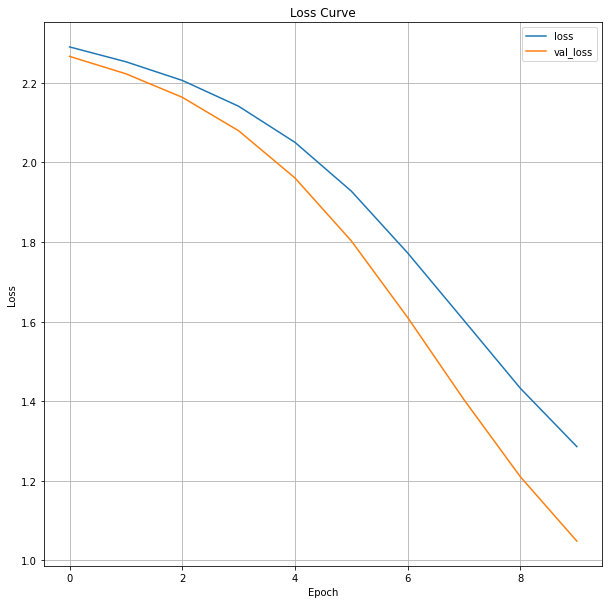

Test loss: 1.0478358268737793
Test accuracy: 0.8019999861717224


In [22]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[slack_])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## How does it look on Slack?

### Slack Channel Looks Good :)
![](https://raw.githubusercontent.com/ssundar6087/Keras-Slack-Logging/master/assets/slack.png)